In [ ]:
from google.colab import drive
ROOT = "/content/drive"  
drive.mount(ROOT)  
%cd "/content/drive/MyDrive/PFE_PIMM/"
%ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/PFE_PIMM
 batch_labeling.ipynb       labeling.ipynb          tomo_labels/
'Copie de labeling.ipynb'   line_to_continuum.mat   visualisation.ipynb
 ct_scan/                   meltpool_bitmap/
 extracting.ipynb           registration.ipynb


In [ ]:
from google.colab.patches import cv2_imshow
from __future__ import print_function
import cv2
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from fnmatch import fnmatch
from IPython.display import clear_output
from scipy.io import savemat

## Functions

In [ ]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

def crop_vid_image(img):
    
    h, w = img.shape[:2]
    # radius = h/2.5
    mask = create_circular_mask(h, w, center=(895, 549), radius = 360)
    masked_img = img.copy()
    cropped_img = img[np.ix_(mask.any(1), mask.any(0))]
    return cropped_img

def map_scale(x, in_min=189, in_max=58, out_min=-0.15, out_max=1.33):
  return ((out_max - out_min)/(float(in_max) - float(in_min)))*(float(x) - float(in_max)) + out_max

def get_value_vid_image(img):
  h, w = img.shape[:2]
  mask = create_circular_mask(h, w, radius = 360)
  masked_img = img.copy()
  value = masked_img[mask]          # extract nonzero values of the array
  value = value.reshape((value.size,1))
  return np.vectorize(map_scale)(value)

## Video Processing

In [ ]:
cap = cv2.VideoCapture('/content/drive/My Drive/PFE_PIMM/meltpool_bitmap/Piece 3.mp4')

line_to_continuum = []

while(cap.isOpened()):
    # Capture frame-by-frame
    ret, frame = cap.read()
    if ret == False:
        break
    # Our operations on the frame come here
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    cropped = crop_vid_image(gray)
    value = get_value_vid_image(cropped)
    line_to_continuum.append(value)

In [ ]:
FrameStack = np.empty((len(line_to_continuum),), dtype=np.object)
for i in range(len(line_to_continuum)):
    FrameStack[i] = line_to_continuum[i]

savemat("line_to_continuum.mat", {"FrameStack":FrameStack})

## Visualisation of a frame sample 


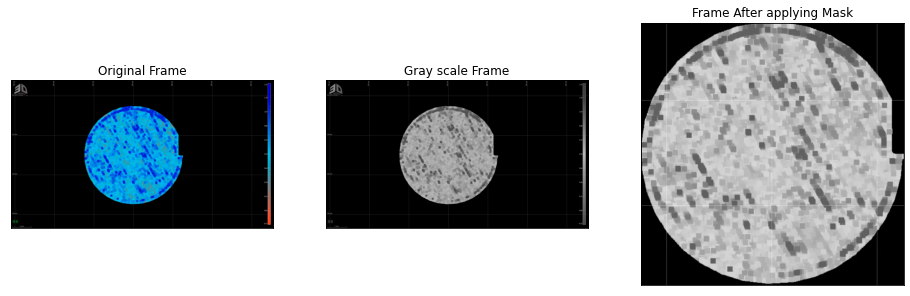

In [ ]:
cap1 = cv2.VideoCapture('/content/drive/My Drive/PFE_PIMM/meltpool_bitmap/Piece 3.mp4')
ret1, frame1 = cap1.read()
gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
cropped1 = crop_vid_image(gray1)

images = [frame1,
          gray1,
          cropped1]
titles = ['Original Frame',
          'Gray scale Frame',
          'Frame After applying Mask']
plt.figure(figsize=(16,9))
for i in range(3):
    plt.subplot(1,3,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()